In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../lecture2/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [5]:
# build vocab of words by mapping characters to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [77]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [78]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [79]:
# initlize embeddings
C = torch.randn((27,2))
C[5]

tensor([0.7298, 0.5236])

In [80]:
oneh = F.one_hot(torch.tensor(5), num_classes=27).float()
oneh

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [81]:
oneh@C

tensor([0.7298, 0.5236])

In [82]:
C[[5,6,7]] # indexing with a list

tensor([[0.7298, 0.5236],
        [0.0553, 0.1492],
        [0.2860, 0.3683]])

In [83]:
C[torch.tensor([5,6,7])] # index with a tensor

tensor([[0.7298, 0.5236],
        [0.0553, 0.1492],
        [0.2860, 0.3683]])

In [84]:
C[X].shape

torch.Size([32, 3, 2])

In [85]:
# to create the embedding simply do this b/c of indexing
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [86]:
W1 = torch.randn((3*2, 100))
b1 = torch.randn(100)

In [87]:
# wont' work because of shape 96x2 vs 6x100 emb @ W1 + b1
# need to transform for multiplication

torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]], 1).shape # concat along dimenions 1,2,3

torch.Size([32, 6])

In [88]:
torch.cat(torch.unbind(emb, 1),1).shape # will be same as above

torch.Size([32, 6])

In [89]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [90]:
a.view(9,2) # view can slice along the dimensions you made 18 so it 2*9 or 9*2 or 3*3\*2

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [91]:
a.storage() # storage remains the same but seen different now

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [92]:
# that means the better way is to simple do:
emb.view(32,6).shape
# does not create new memory, cat does!!!

torch.Size([32, 6])

In [93]:
h = emb.view(-1,6) @ W1 + b1 # -1 infers what shape is

In [94]:
h.shape

torch.Size([32, 100])

In [95]:
# 32, 100 broadcasting to 1,100 -> copy vertical and do elemenwise op
W2=torch.randn((100,27))
b2 = torch.randn(27)

In [96]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [97]:
counts = logits.exp()

In [98]:
prob =counts/counts.sum(1,keepdims=True)

In [99]:
prob[0].sum()

tensor(1.)

In [100]:
Y # next character in the sequence

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [101]:
prob[torch.arange(32), Y] # give probs given character in seq

tensor([1.6629e-30, 1.0000e+00, 2.4572e-12, 9.9142e-26, 3.1736e-18, 4.3320e-11,
        6.3650e-13, 2.2542e-12, 1.0562e-03, 3.0029e-18, 4.1087e-29, 5.8526e-23,
        1.6572e-24, 2.5132e-24, 3.7835e-44, 6.1564e-29, 9.1440e-15, 1.9510e-09,
        1.9132e-24, 1.2707e-28, 0.0000e+00, 0.0000e+00, 5.8877e-24, 4.5587e-11,
        4.0176e-19, 1.5181e-11, 4.8619e-14, 1.4750e-14, 2.6583e-21, 3.0945e-33,
        1.5302e-10, 1.6222e-16])

In [102]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(inf)

In [109]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


In [110]:
sum(p.nelement() for p in parameters)

3481

In [111]:
C = torch.randn((27, 2))
emb = C[X]

emb = C[X] # 32,3,2
h = torch.tanh(emb.view(-1,6) @ W1+b1) # 32,100
logits = h @ W2 + b2# 32,27
#counts = logits.exp()
#prob = counts/ counts.sum(1, keepdims=True)
#loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y) # same and better - stable numerically, forward and backward pass effeicnet
loss

tensor(18.8630)

In [112]:
emb.shape

torch.Size([32, 3, 2])

In [113]:
for p in parameters:
    p.requires_grad = True

In [114]:
for _ in range(10):
    # forward pass
    emb = C[X] #32,3,2
    h = torch.tanh(emb.view(-1,6) @ W1+b1) #32,100
    logits = h @ W2 + b2 #32,27
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    # update 
    for p in parameters:
        p.data += -0.1 * p.grad

18.863037109375


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [116]:
logits.max(1)

torch.return_types.max(
values=tensor([11.1712,  8.1745, 20.0038, 14.9948, 24.3707, 11.1712,  6.6190, 18.2587,
         7.7985, 19.7036, 16.9716, 10.3807, 11.1712, 13.6289, 11.3921, 22.8329,
        11.1712, 10.3474, 22.6348, 15.1041, 26.4070, 11.8413, 14.4034, 10.0087,
        23.6262, 11.1712, 14.4645, 14.3213, 21.5298, 16.5175, 14.6925,  8.7798],
       grad_fn=<MaxBackward0>),
indices=tensor([11, 11,  2,  2, 10, 11, 25, 10, 10, 10, 10, 21, 11, 11, 25, 10, 11, 11,
         2, 10, 10, 10,  2,  2, 10, 11,  2, 10, 10, 22, 22,  2]))

In [117]:
Y # indices are close to labels but differ

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

# Run on Whole Dataset

In [6]:

# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, X.dtype, Y.shape, Y.dtype
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# train, valid, test splits
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
print(n1,n2, n2-n1)
print(Xtr.shape, Xdev.shape, Xte.shape)

25626 28829 3203
torch.Size([182625, 3]) torch.Size([22655, 3]) torch.Size([22866, 3])


In [21]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g) # 3 words * 10 inputs
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [22]:
for p in parameters:
  p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

1.7684301137924194


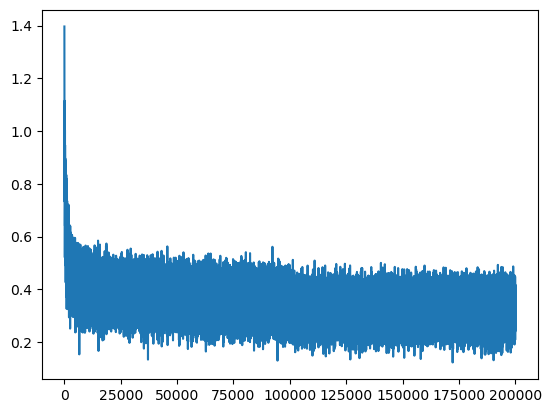

In [23]:
print(loss.item())
plt.plot(stepi, lossi)

In [24]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print("Training loss", loss)

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print("Dev loss", loss)

Training loss tensor(2.1288, grad_fn=<NllLossBackward0>)
Dev loss tensor(2.1711, grad_fn=<NllLossBackward0>)


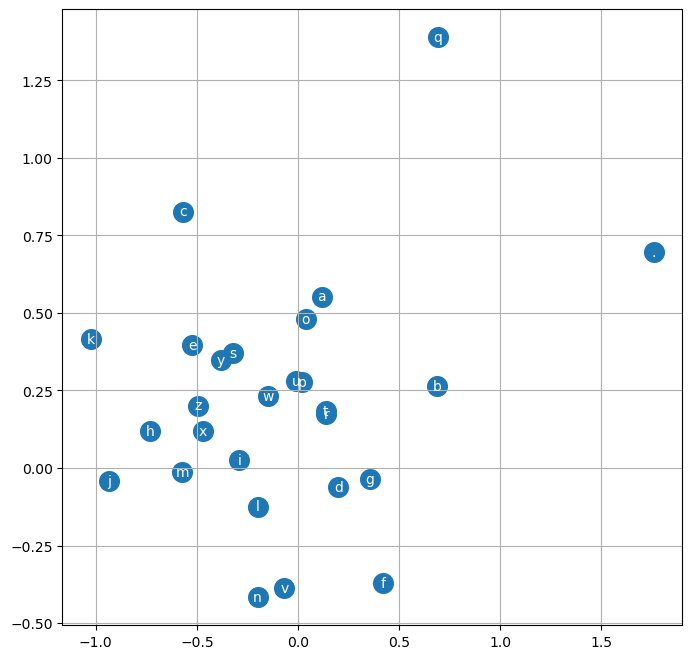

In [25]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [27]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
amelle.
khy.
mili.
thiyah.
cassie.
rahnen.
delyah.
jareei.
nellara.
chaiia.
kaleigh.
ham.
joia.
quinn.
shous.
alianni.
wanthon.
jaryxi.
jace.
